# Load Data

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:


trDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (3835, 224, 224, 3), (3835,), (959, 224, 224, 3), (959,)


Showing 878 index image, It is 0.0


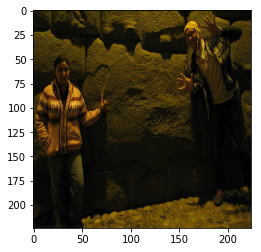

Showing 399 index image, It is 1.0


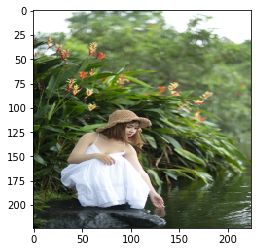

Showing 927 index image, It is 0.0


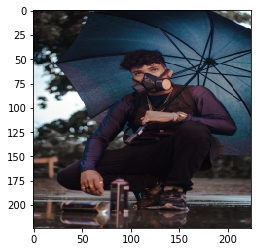

Showing 409 index image, It is 1.0


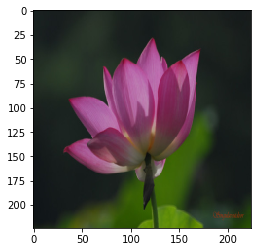

Showing 449 index image, It is 1.0


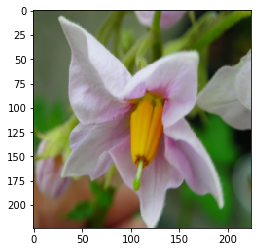

In [5]:
# Randomly show 5 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(5):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# # reshape the data to be [samples][width][height][channel]
# # This is required by Keras framework
# trDat       = trDat.reshape(trDat.shape[0], imgrows, imgclms, channel)
# tsDat       = tsDat.reshape(tsDat.shape[0], imgrows, imgclms, channel)

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

# Define Model

In [9]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

modelname = 'FlowerPower_VGG_Baseline'

def createBaseVGGModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_1_1')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_2_1')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv2d_3_1')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='dense_1')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = createBaseVGGModel()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1_1 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2_1 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3_1 (Conv2D)          (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 256)       0   

In [0]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
#                                  monitor='val_acc', 
                                  monitor='val_loss',
                                  verbose=0, 
                                  save_best_only=True, 
#                                  mode='max')
                                  mode='min')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
# callbacks_list  = [checkpoint, csv_logger, LRScheduler]
callbacks_list  = [checkpoint, csv_logger]

In [7]:
# Fit the model
# This is where the training starts
# model.fit(trDat, 
#           trLbl, 
#           validation_data=(tsDat, tsLbl), 
#           epochs=120, 
#           batch_size=16,
#           callbacks=callbacks_list)

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True,
                             vertical_flip=False)

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=20, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Epoch 1/20
120/119 [==============================] - 62s 521ms/step - loss: 1.0132 - acc: 0.6396 - val_loss: 0.5696 - val_acc: 0.7581
Epoch 2/20
120/119 [==============================] - 54s 451ms/step - loss: 0.5422 - acc: 0.7392 - val_loss: 0.5115 - val_acc: 0.7727
Epoch 3/20
120/119 [==============================] - 54s 451ms/step - loss: 0.4976 - acc: 0.7638 - val_loss: 0.4754 - val_acc: 0.7831
Epoch 4/20
120/119 [==============================] - 54s 451ms/step - loss: 0.4518 - acc: 0.8013 - val_loss: 0.3972 - val_acc: 0.8384
Epoch 5/20
120/119 [==============================] - 38s 317ms/step - loss: 0.3941 - acc: 0.8292 - val_loss: 0.4865 - val_acc: 0.7852
Epoch 6/20
120/119 [==============================] - 54s 453ms/step - loss: 0.3970 - acc: 0.8232 - val_loss: 0.3380 - val_acc: 0.8561
Epoch 7/20
120/119 [==============================] - 38s 314ms/step - loss: 0.3678 - acc: 0.8370 - val_loss: 0.3769 - val_acc: 0.8405
Epoch 8/20
120/119 [==============================] - 5

In [11]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

modelname = 'FlowerPower_VGG_Mod1'
optmz     = optimizers.RMSprop(lr=0.0001)

def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 110:
        lr  *= 1e-3
        
    elif epoch > 100:
        lr  *= 1e-2
        
    elif epoch > 70:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)
  
def createMod1VGGModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_1_1')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_1_2', kernel_initializer='he_normal')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_2_1')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_2_2', kernel_initializer='he_normal')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv2d_3_1')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv2d_3_2', kernel_initializer='he_normal')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model_mod1 = createMod1VGGModel()

model_mod1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1_1 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1_2 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2_1 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2_2 (Conv2D)          (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0   

In [0]:
# Load the base model weights to Mod1 with layer matched by name

model_mod1.load_weights(filepath, by_name=True)

In [0]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
#                                  monitor='val_acc', 
                                  monitor='val_loss',
                                  verbose=0, 
                                  save_best_only=True, 
#                                  mode='max')
                                  mode='min')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint, csv_logger, LRScheduler]
# callbacks_list  = [checkpoint, csv_logger]

In [14]:
# Fit the model
# This is where the training starts
# model.fit(trDat, 
#           trLbl, 
#           validation_data=(tsDat, tsLbl), 
#           epochs=120, 
#           batch_size=16,
#           callbacks=callbacks_list)

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True,
                             vertical_flip=False)

model_mod1.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=120, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/120
120/119 [==============================] - 79s 660ms/step - loss: 0.6171 - acc: 0.6464 - val_loss: 0.5047 - val_acc: 0.7351
Learning rate:  0.001
Epoch 2/120
120/119 [==============================] - 61s 512ms/step - loss: 0.5115 - acc: 0.7671 - val_loss: 0.4588 - val_acc: 0.7883
Learning rate:  0.001
Epoch 3/120
120/119 [==============================] - 62s 517ms/step - loss: 0.4454 - acc: 0.8000 - val_loss: 0.3920 - val_acc: 0.8394
Learning rate:  0.001
Epoch 4/120
120/119 [==============================] - 46s 381ms/step - loss: 0.4423 - acc: 0.8010 - val_loss: 0.4170 - val_acc: 0.8415
Learning rate:  0.001
Epoch 5/120
120/119 [==============================] - 62s 514ms/step - loss: 0.3851 - acc: 0.8402 - val_loss: 0.3606 - val_acc: 0.8498
Learning rate:  0.001
Epoch 6/120
120/119 [==============================] - 62s 516ms/step - loss: 0.3614 - acc: 0.8514 - val_loss: 0.3273 - val_acc: 0.8603
Learning rate:  0.001
Epoch 7/120
120/119 [=========

In [0]:
## Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo = createMod1VGGModel()
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [16]:
# Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['flower', 'non-flower']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 90.62%
              precision    recall  f1-score   support

      flower     0.8913    0.8955    0.8934       421
  non-flower     0.9179    0.9145    0.9162       538

    accuracy                         0.9062       959
   macro avg     0.9046    0.9050    0.9048       959
weighted avg     0.9062    0.9062    0.9062       959

[[377  44]
 [ 46 492]]


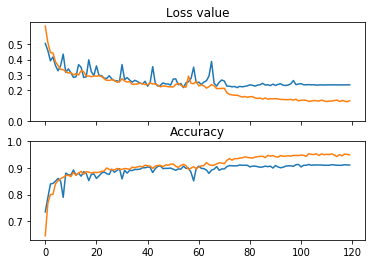

In [17]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.30, 0.4, 0.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

In [0]:
wrong_ans_index = []

for i in range(len(predout)):
    if predout[i] != testout[i]:
        wrong_ans_index.append(i)

In [0]:
wrong_ans_index = list(set(wrong_ans_index))

Showing 636 index image
Predicted as 1 but is actually 0


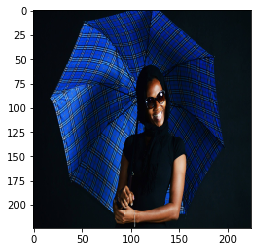

Showing 628 index image
Predicted as 1 but is actually 0


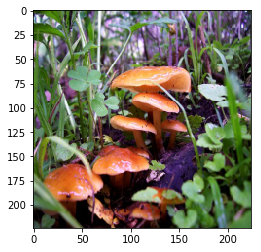

Showing 700 index image
Predicted as 1 but is actually 0


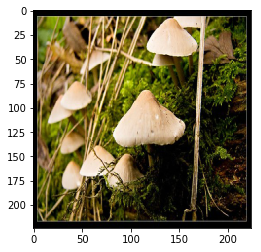

Showing 453 index image
Predicted as 0 but is actually 1


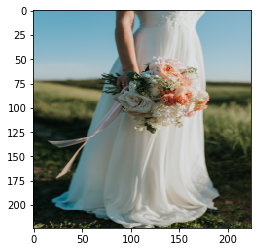

Showing 151 index image
Predicted as 0 but is actually 1


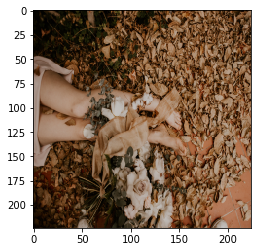

Showing 564 index image
Predicted as 1 but is actually 0


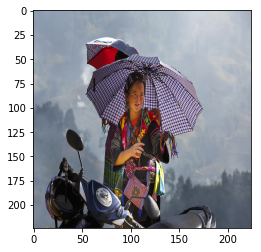

Showing 235 index image
Predicted as 0 but is actually 1


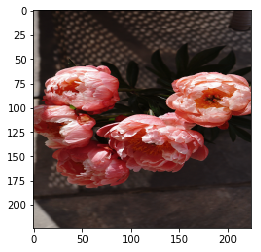

Showing 501 index image
Predicted as 0 but is actually 1


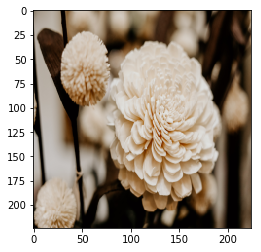

Showing 220 index image
Predicted as 0 but is actually 1


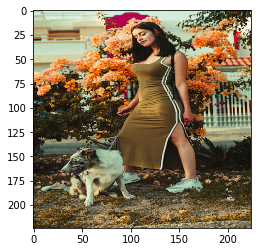

Showing 335 index image
Predicted as 0 but is actually 1


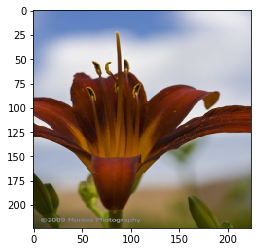

In [20]:
# Randomly show X examples of that was wrong

dataset = tsDatOrg #flowers #fungus #rocks

for index in range(10):
    index = wrong_ans_index[random.randint(0, len(wrong_ans_index)-1)]
    print("Showing %s index image" %(index))
    print("Predicted as %s but is actually %s" %(predout[index], testout[index]))
    imgplot = plt.imshow(data[index])
    plt.show()